# 12-Class SSVEP EEG Dataset - Classification Using Convolutional Neural Network
User-Dependent Training using Magnitude Spectrum Features and Complex Spectrum Features
(10-Fold Cross-validation)

Following implementation is an asynchronous SSVEP BCI using Convolutional Neural Network classification for 1 second data length.

Reference Paper: [Comparing user-dependent and user-independent training of CNN for SSVEP BCI](https://iopscience.iop.org/article/10.1088/1741-2552/ab6a67)


In [ ]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

In [1]:
%%capture
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn.model_selection import KFold

from keras.utils.np_utils import to_categorical
from keras import optimizers
from keras.losses import categorical_crossentropy

from scripts import ssvep_utils as su
warnings.filterwarnings('ignore')

In [2]:
def get_training_data(features_data):
    features_data = np.reshape(features_data, (features_data.shape[0], features_data.shape[1], 
                                               features_data.shape[2], 
                                               features_data.shape[3]*features_data.shape[4]))
    train_data = features_data[:, :, 0, :].T
    for target in range(1, features_data.shape[2]):
        train_data = np.vstack([train_data, np.squeeze(features_data[:, :, target, :]).T])

    train_data = np.reshape(train_data, (train_data.shape[0], train_data.shape[1], 
                                         train_data.shape[2], 1))
    total_epochs_per_class = features_data.shape[3]
    features_data = []
    class_labels = np.arange(CNN_PARAMS['num_classes'])
    labels = (np.matlib.repmat(class_labels, total_epochs_per_class, 1).T).ravel()
    labels = to_categorical(labels)
    
    return train_data, labels

In [3]:
def train_CNN_cross_val_predict(train_data, labels, num_folds=10):
    kf = KFold(n_splits=num_folds, shuffle=True)
    kf.get_n_splits(train_data)
    cv_acc = np.zeros((num_folds, 1))
    fold = -1

    for train_index, test_index in kf.split(train_data):
        x_tr, x_ts = train_data[train_index], train_data[test_index]
        y_tr, y_ts = labels[train_index], labels[test_index]
        input_shape = np.array([x_tr.shape[1], x_tr.shape[2], x_tr.shape[3]])
        
        fold = fold + 1
        
        model = su.CNN_model(input_shape, CNN_PARAMS)
        
        sgd = optimizers.SGD(lr=CNN_PARAMS['learning_rate'], decay=CNN_PARAMS['lr_decay'], 
                             momentum=CNN_PARAMS['momentum'], nesterov=False)
        model.compile(loss=categorical_crossentropy, optimizer=sgd, metrics=["accuracy"])
        history = model.fit(x_tr, y_tr, batch_size=CNN_PARAMS['batch_size'], 
                            epochs=CNN_PARAMS['epochs'], verbose=0)

        score = model.evaluate(x_ts, y_ts, verbose=0) 
        cv_acc[fold, :] = score[1]*100
        print(f'cv{fold+1}:{score[1]*100:.2f}%', end=" ")
    
    return cv_acc

In [4]:
data_path = os.path.abspath('../data')

CNN_PARAMS = {
    'batch_size': 64,
    'epochs': 50,
    'droprate': 0.25,
    'learning_rate': 0.001,
    'lr_decay': 0.0,
    'l2_lambda': 0.0001,
    'momentum': 0.9,
    'kernel_f': 10,
    'n_ch': 8,
    'num_classes': 12}

FFT_PARAMS = {
    'resolution': 0.2930,
    'start_frequency': 3.0,
    'end_frequency': 35.0,
    'sampling_rate': 256
}

window_len = 1
shift_len = 1
    
all_acc = np.zeros((10, 1))

magnitude_spectrum_features = dict()
complex_spectrum_features = dict()

In [5]:
mcnn_training_data = dict()
ccnn_training_data = dict()

In [6]:
mcnn_results = dict()
ccnn_results = dict()

# Load Dataset and Segment

In [7]:
all_segmented_data = dict()
for subject in range(0, 10):
    dataset = sio.loadmat(f'{data_path}/s{subject+1}.mat')
    eeg = np.array(dataset['eeg'], dtype='float32')
    
    CNN_PARAMS['num_classes'] = eeg.shape[0]
    CNN_PARAMS['n_ch'] = eeg.shape[1]
    total_trial_len = eeg.shape[2]
    num_trials = eeg.shape[3]
    sample_rate = 256

    filtered_data = su.get_filtered_eeg(eeg, 6, 80, 4, sample_rate)
    all_segmented_data[f's{subject+1}'] = su.get_segmented_epochs(filtered_data, window_len, 
                                                                  shift_len, sample_rate)

# Feature Extraction

In [8]:
for subject in all_segmented_data.keys():
    magnitude_spectrum_features[subject] = su.magnitude_spectrum_features(all_segmented_data[subject], 
                                                                          FFT_PARAMS)
    complex_spectrum_features[subject] = su.complex_spectrum_features(all_segmented_data[subject], 
                                                                      FFT_PARAMS)

In [9]:
for subject in all_segmented_data.keys():
    mcnn_training_data[subject] = dict()
    ccnn_training_data[subject] = dict()
    train_data, labels = get_training_data(magnitude_spectrum_features[subject])
    mcnn_training_data[subject]['train_data'] = train_data
    mcnn_training_data[subject]['label'] = labels
    
    train_data, labels = get_training_data(complex_spectrum_features[subject])
    ccnn_training_data[subject]['train_data'] = train_data
    ccnn_training_data[subject]['label'] = labels

# M-CNN Training and Results

In [10]:
for subject in mcnn_training_data.keys():
    print(f'\nMCNN - Subject: {subject}')
    train_data = mcnn_training_data[subject]['train_data']
    labels = mcnn_training_data[subject]['label']
    
    cv_acc = train_CNN_cross_val_predict(train_data, labels, 10)
    mcnn_results[subject] = np.mean(cv_acc)
    print(f'\nAccuracy: {mcnn_results[subject]:2f}%')

mcnn_overall_accuracy = np.mean(np.fromiter(mcnn_results.values(), dtype=float))    
print(f'Overall Accuracy MCNN - {mcnn_overall_accuracy:.2f}%')


MCNN - Subject: s1
cv1:72.22% cv2:54.17% cv3:61.11% cv4:66.67% cv5:58.33% cv6:59.72% cv7:69.44% cv8:77.78% cv9:62.50% cv10:62.50% 
Accuracy: 64.444444%

MCNN - Subject: s2
cv1:31.94% cv2:41.67% cv3:30.56% cv4:43.06% cv5:27.78% cv6:45.83% cv7:40.28% cv8:40.28% cv9:43.06% cv10:37.50% 
Accuracy: 38.194444%

MCNN - Subject: s3
cv1:90.28% cv2:75.00% cv3:79.17% cv4:81.94% cv5:81.94% cv6:87.50% cv7:86.11% cv8:86.11% cv9:80.56% cv10:81.94% 
Accuracy: 83.055556%

MCNN - Subject: s4
cv1:87.50% cv2:94.44% cv3:93.06% cv4:90.28% cv5:86.11% cv6:91.67% cv7:88.89% cv8:95.83% cv9:90.28% cv10:90.28% 
Accuracy: 90.833333%

MCNN - Subject: s5
cv1:93.06% cv2:91.67% cv3:95.83% cv4:93.06% cv5:95.83% cv6:98.61% cv7:93.06% cv8:98.61% cv9:94.44% cv10:97.22% 
Accuracy: 95.138889%

MCNN - Subject: s6
cv1:94.44% cv2:91.67% cv3:93.06% cv4:95.83% cv5:100.00% cv6:98.61% cv7:100.00% cv8:90.28% cv9:94.44% cv10:94.44% 
Accuracy: 95.277778%

MCNN - Subject: s7
cv1:93.06% cv2:91.67% cv3:87.50% cv4:87.50% cv5:90.28% cv6:9

# C-CNN Training and Results

In [12]:
for subject in ccnn_training_data.keys():
    print(f'\nCCNN - Subject: {subject}')
    train_data = ccnn_training_data[subject]['train_data']
    labels = ccnn_training_data[subject]['label']
    
    cv_acc = train_CNN_cross_val_predict(train_data, labels, 10)
    ccnn_results[subject] = np.mean(cv_acc)
    print(f'\nAccuracy: {ccnn_results[subject]:.2f}%')

ccnn_overall_accuracy = np.mean(np.fromiter(ccnn_results.values(), dtype=float))    
print(f'Overall Accuracy CCNN - {ccnn_overall_accuracy:.2f}%')


CCNN - Subject: s1
cv1:86.11% cv2:63.89% cv3:79.17% cv4:76.39% cv5:81.94% cv6:72.22% cv7:73.61% cv8:73.61% cv9:77.78% cv10:81.94% 
Accuracy: 76.67%

CCNN - Subject: s2
cv1:56.94% cv2:68.06% cv3:62.50% cv4:55.56% cv5:59.72% cv6:51.39% cv7:58.33% cv8:50.00% cv9:51.39% cv10:50.00% 
Accuracy: 56.39%

CCNN - Subject: s3
cv1:97.22% cv2:97.22% cv3:95.83% cv4:88.89% cv5:95.83% cv6:90.28% cv7:93.06% cv8:97.22% cv9:94.44% cv10:100.00% 
Accuracy: 95.00%

CCNN - Subject: s4
cv1:100.00% cv2:98.61% cv3:97.22% cv4:97.22% cv5:98.61% cv6:95.83% cv7:100.00% cv8:98.61% cv9:100.00% cv10:97.22% 
Accuracy: 98.33%

CCNN - Subject: s5
cv1:100.00% cv2:100.00% cv3:100.00% cv4:100.00% cv5:100.00% cv6:100.00% cv7:98.61% cv8:100.00% cv9:100.00% cv10:100.00% 
Accuracy: 99.86%

CCNN - Subject: s6
cv1:100.00% cv2:100.00% cv3:100.00% cv4:100.00% cv5:98.61% cv6:100.00% cv7:100.00% cv8:100.00% cv9:98.61% cv10:100.00% 
Accuracy: 99.72%

CCNN - Subject: s7
cv1:94.44% cv2:94.44% cv3:91.67% cv4:94.44% cv5:94.44% cv6:93.06%

# Summary

In [16]:
results = pd.DataFrame({'mcnn': np.fromiter(mcnn_results.values(), dtype=float), 
              'ccnn': np.fromiter(ccnn_results.values(), dtype=float)})

In [45]:
print(results)

        ccnn       mcnn
0  76.666667  64.444444
1  56.388889  38.194444
2  95.000000  83.055556
3  98.333333  90.833333
4  99.861111  95.138889
5  99.722222  95.277778
6  94.305556  90.416667
7  98.888889  97.777778
8  98.055556  88.750000
9  89.583333  80.416667


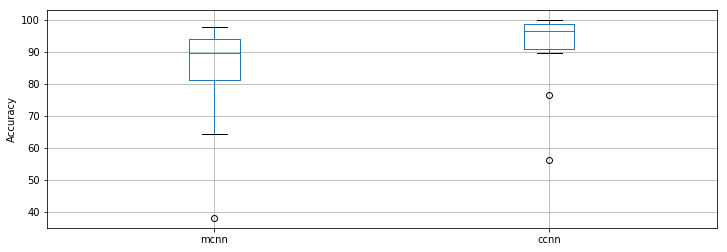

In [44]:
results.boxplot(figsize=(12, 4), column=['mcnn', 'ccnn'])
plt.ylabel('Accuracy')
plt.show()

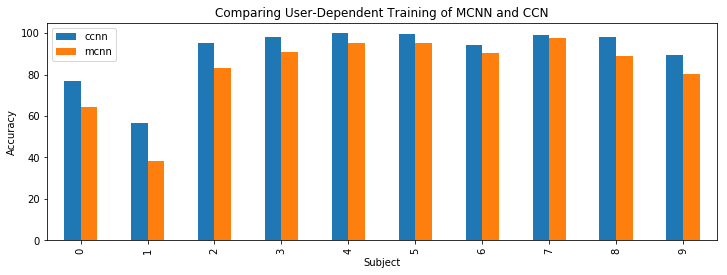

In [42]:
results.plot.bar(figsize=(12, 4), title='Comparing User-Dependent Training of MCNN and CCN')
plt.xlabel('Subject')
plt.ylabel('Accuracy')
plt.show()